# Part 1: Clustering and Dimensionality Reduction

## 1a: Preprocessing

In [16]:
import polars as pl
import pandas as pd 

# Load datasets
demo = pd.read_csv("DemoStats.csv")
spend = pd.read_csv("HouseholdSpend.csv")

# Display basic info
print("DemoStats shape:", demo.shape)
print("HouseholdSpend shape:", spend.shape)

# Peek at both datasets
print("\nDemoStats preview:\n", demo.head())
print("\nHouseholdSpend preview:\n", spend.head())

# Check for a shared key column
print("\nCommon columns:", set(demo.columns).intersection(set(spend.columns)))

DemoStats shape: (868970, 736)
HouseholdSpend shape: (868970, 246)

DemoStats preview:
      CODE     GEO  ECYASQKM  ECYALSQKM  ECYBASPOP  ECYBASHHD  ECYBASHPOP  \
0  A0A0A0  FSALDU         0          0          0          0           0   
1  A0A1A0  FSALDU         0          0         55         33          55   
2  A0A1B0  FSALDU         0          0        588        243         588   
3  A0A1C0  FSALDU         0          0       1793        709        1791   
4  A0A1E0  FSALDU         0          0        452        176         449   

   ECYBAS12P  ECYBAS15P  ECYBAS18P  ...  ECYGEN1GEN  ECYGEN2GEN  ECYGEN3GEN  \
0          0          0          0  ...           0           0           0   
1         55         55         55  ...           0           0          55   
2        561        512        475  ...          11          14         563   
3       1548       1465       1405  ...          50          32        1709   
4        415        389        357  ...          10         

### Noting some relevant variables:

**Variables related to retirement/pension contributions**
- HSEP001 - Total personal insurance premiums and retirement/pension contributions
- HSEP002 - Employment and Quebec parental insurance premiums
- HSEP003 - Retirement and pension fund payments
- HSEP004 - Total Canada/Quebec Pension Plan payments
- HSEP005 - Payments to retirement or pension funds
- HSEP006 - Annuity contracts and transfers to RRIFs
- HSEP007 - Premiums on life, term and endowment insurance
- HSEP008 - Employment insurance premiums
- HSEP009 - Quebec parental insurance premiums

**Variables related to household income**
- HSHNIAGG	Household Income	Basics	1	Household Income
- HSAGDISPIN	Household Disposable Income	Basics	1	Household Disposable Income
- HSAGDISCIN	Household Discretionary Income	Basics	1	Household Discretionary Income
- HSTT001	Total expenditure	Household Expenditures (Category Summary)	1	Total expenditure
- HSTE001	Total current consumption and financial transfers	Household Expenditures (Category Summary)	2	    Total current consumption and financial transfers
- HSTX001	Income tax	Household Expenditures (Category Summary)	3	        Income tax

There are relevant [discord message 1](https://discord.com/channels/1324440156727677051/1324779389056974962/1355180722675253279) and [discord message 2](https://discord.com/channels/1324440156727677051/1324440156727677055/1353730870393049088) that suggest what we need to drop

In [17]:
from sklearn.preprocessing import StandardScaler

# Merge on common columns
data = pd.merge(demo, spend, on=["CODE", "GEO"], how="inner")

# Drop identifier columns
data = data.drop(columns=["CODE", "GEO"])

# Define variables to remove (targets or derived)
vars_to_remove = [
    "HSEP001", "HSEP002", "HSEP003", "HSEP004", "HSEP005",
    "HSEP006", "HSEP007", "HSEP008", "HSEP009",
    "HSHNIAGG", "HSAGDISPIN", "HSAGDISCIN"
]

# Also remove likely target-related columns based on patterns
target_pattern_cols = [col for col in data.columns if "HSTR056" in col or "HSTR057" in col]

# Drop all target-related columns
data = data.drop(columns=vars_to_remove + target_pattern_cols, errors="ignore")

# Drop columns with all same values (including all zeros)
low_variance_cols = data.columns[data.nunique() <= 1]
data = data.drop(columns=low_variance_cols)

# Drop rows with missing values
data = data.dropna()

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Output shape of cleaned and scaled data
print("Final cleaned shape:", data_scaled.shape)

Final cleaned shape: (722081, 969)


## 1b K-Means Clustering

Since the dataset is so large, and our machines are not so powerful in comparison, we can use the elbow and silhouette methods on a sample of the data to get an idea of what the number of clusters should be. Based on that we can run one (or just much fewer) KMeans on the full dataset.

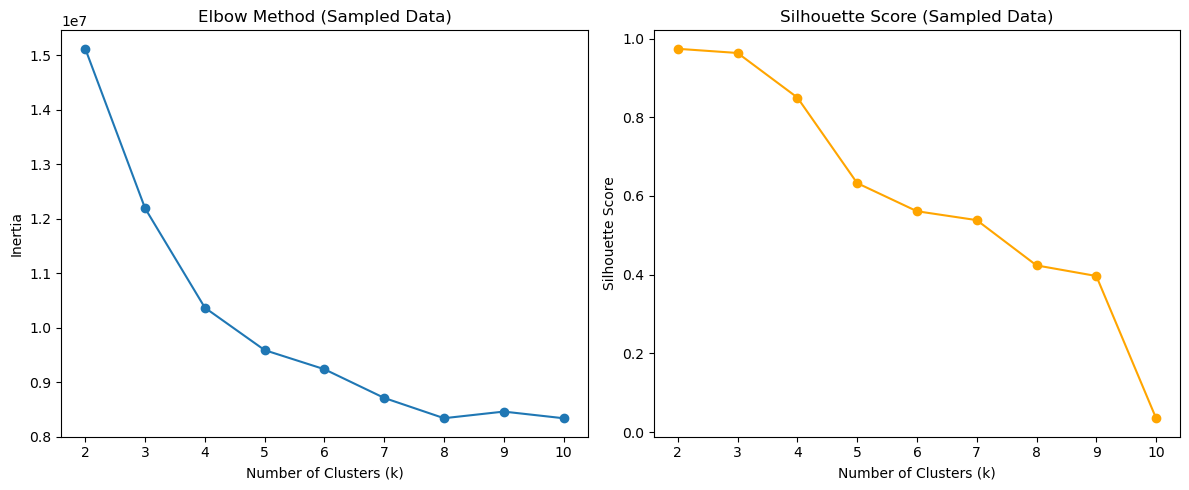

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# === STEP 1: Sample the data ===
sample_size = 20000 
rng = np.random.default_rng(seed=42)
sample_idx = rng.choice(data_scaled.shape[0], size=sample_size, replace=False)
sample = data_scaled[sample_idx]

# === STEP 2: Try different cluster counts ===
range_n_clusters = list(range(2, 11))
inertias = []
silhouette_scores = []

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(sample)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(sample, labels))

# === STEP 3: Plot elbow and silhouette ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertias, marker='o')
plt.title("Elbow Method (Sampled Data)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='orange')
plt.title("Silhouette Score (Sampled Data)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


TODO: Discuss difference

In [22]:

# Fit KMeans for k = 3 and k = 4 on full standardized data
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels_3 = kmeans_3.fit_predict(data_scaled)

kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init='auto')
labels_4 = kmeans_4.fit_predict(data_scaled)

# Optionally: add these labels to a DataFrame for inspection later
clustered_df = pd.DataFrame(data_scaled, columns=[f"var_{i}" for i in range(data_scaled.shape[1])])
clustered_df["cluster_3"] = labels_3
clustered_df["cluster_4"] = labels_4

## 1c Dimensionality Reduction

In [23]:
from sklearn.decomposition import PCA

# Run PCA on full standardized data
pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)

# Explained variance for each component
print("Explained variance ratio (PC1–PC3):", pca.explained_variance_ratio_)

Explained variance ratio (PC1–PC3): [0.5418277  0.05510973 0.02217764]


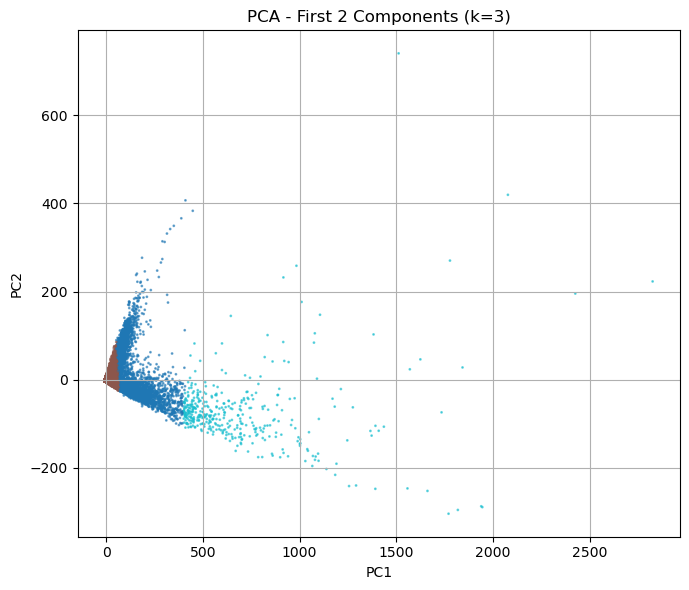

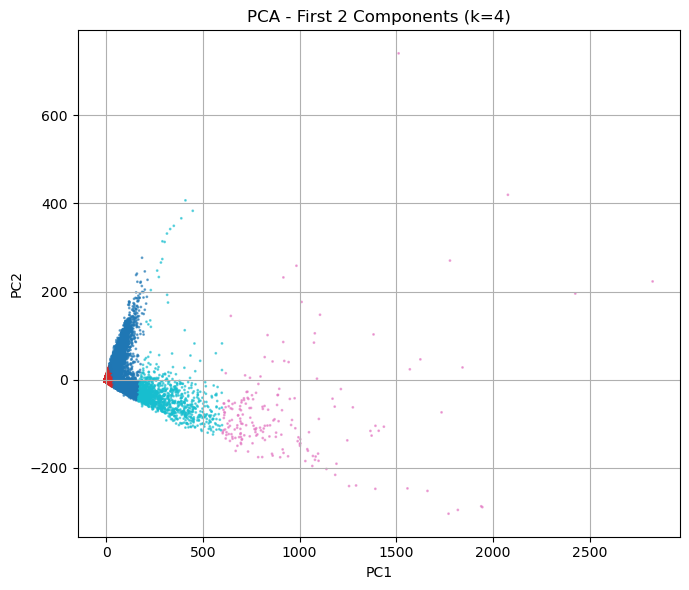

In [24]:
def plot_clusters(pca_data, labels, k):
    plt.figure(figsize=(7, 6))
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='tab10', s=1, alpha=0.6)
    plt.title(f"PCA - First 2 Components (k={k})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for k=3 and k=4
plot_clusters(pca_data, labels_3, k=3)
plot_clusters(pca_data, labels_4, k=4)

In [25]:
# Create DataFrame with PCA results and cluster labels
pca_df = pd.DataFrame(pca_data, columns=["PC1", "PC2", "PC3"])
pca_df["cluster_3"] = labels_3
pca_df["cluster_4"] = labels_4

# Mean values for each component per cluster
mean_pcs_k3 = pca_df.groupby("cluster_3")[["PC1", "PC2", "PC3"]].mean()
mean_pcs_k4 = pca_df.groupby("cluster_4")[["PC1", "PC2", "PC3"]].mean()

print("\nMean PC values per cluster (k=3):")
print(mean_pcs_k3)

print("\nMean PC values per cluster (k=4):")
print(mean_pcs_k4)


Mean PC values per cluster (k=3):
                  PC1        PC2       PC3
cluster_3                                 
0          127.106046  19.145049  2.229789
1           -1.256719  -0.089678 -0.015181
2          685.591596 -72.595933 -0.092623

Mean PC values per cluster (k=4):
                  PC1        PC2       PC3
cluster_4                                 
0           52.882152  24.650250  2.084549
1           -1.781812  -0.388583 -0.045080
2          919.872347 -78.562783 -5.250304
3          285.211537 -35.869501  3.523483


In [27]:
# Create a DataFrame for PCA loadings
pca_loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2", "PC3"],
    index=data.columns  # original variable names
)

# Show top absolute contributors to PC1
top_pc1 = pca_loadings["PC1"].abs().sort_values(ascending=False).head(20)
print("Top contributing variables to PC1:")
print(pca_loadings.loc[top_pc1.index].sort_values("PC1", ascending=False))

# Show top absolute contributors to PC2
top_pc2 = pca_loadings["PC2"].abs().sort_values(ascending=False).head(20)
print("Top contributing variables to PC2:")
print(pca_loadings.loc[top_pc2.index].sort_values("PC2", ascending=False))

Top contributing variables to PC1:
                 PC1       PC2       PC3
ECYBAS12HP  0.043383 -0.005534  0.009617
ECYPOWHPL   0.043378 -0.005439  0.009312
ECYMARHP15  0.043378 -0.005439  0.009312
ECYINDHPL   0.043378 -0.005439  0.009312
ECYBAS15HP  0.043378 -0.005439  0.009312
ECYTRAHPL   0.043378 -0.005439  0.009312
ECYEDUHP15  0.043378 -0.005439  0.009312
ECYACTHPL   0.043378 -0.005439  0.009312
ECYCWHPL    0.043378 -0.005439  0.009312
ECYPNIHP15  0.043378 -0.005439  0.009312
ECYOCCHPL   0.043378 -0.005439  0.009312
ECYBAS18HP  0.043375 -0.005361  0.009493
ECYBAS19HP  0.043369 -0.005377  0.009608
ECYMOBHPOP  0.043367 -0.005655  0.010464
ECYPNIWIN   0.043360 -0.006595  0.009800
ECYHOMHPOP  0.043346 -0.005441  0.011307
ECYRIMHPOP  0.043346 -0.005441  0.011307
ECYTIMHPOP  0.043346 -0.005441  0.011307
ECYMOTHPOP  0.043346 -0.005441  0.011307
ECYKNOHPOP  0.043346 -0.005441  0.011307
Top contributing variables to PC2:
                 PC1       PC2       PC3
ECYVISVM    0.021218  0.1121